In [15]:
import warnings
warnings.filterwarnings(action='ignore')

In [16]:
import cv2, os, glob
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Input, Activation
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from skimage.transform import pyramid_expand
from Subpixel import Subpixel
from DataGenerator import DataGenerator

In [25]:
base_path = r'C:\project\celeba-dataset\processed'

x_train_list = sorted(glob.glob(os.path.join(base_path, 'x_train', '*.npy')))
x_val_list = sorted(glob.glob(os.path.join(base_path, 'x_val', '*.npy')))

print(len(x_train_list), len(x_val_list)) # 18650 5700
print(x_train_list[0]) # C:\project\celeba-dataset\processed\x_train\000001.npy

18650 5700
C:\project\celeba-dataset\processed\x_train\000001.npy


(44, 44, 1) (44, 44, 1)


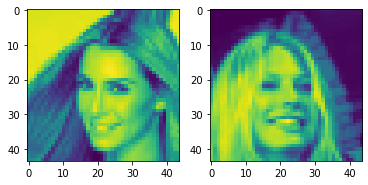

In [28]:
x1 = np.load(x_train_list[0])
x2 = np.load(x_val_list[0])

print(x1.shape, x2.shape)

plt.subplot(1, 2, 1)
plt.imshow(x1)
plt.subplot(1, 2, 2)
plt.imshow(x2)

In [20]:
train_gen = DataGenerator(list_IDs=x_train_list, 
                          labels=None, 
                          batch_size=16, 
                          dim=(44,44), 
                          n_channels=3, 
                          n_classes=None, 
                          shuffle=True)

val_gen = DataGenerator(list_IDs=x_val_list, 
                        labels=None, 
                        batch_size=16, 
                        dim=(44,44), 
                        n_channels=3, 
                        n_classes=None, 
                        shuffle=False)

In [8]:
upscale_factor = 4

inputs = Input(shape=(44, 44, 3))

net = Conv2D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
net = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Conv2D(filters=upscale_factor**2, kernel_size=3, strides=1, padding='same', activation='relu')(net)
net = Subpixel(filters=3, kernel_size=3, r=upscale_factor, padding='same')(net)
outputs = Activation('relu')(net)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 44, 44, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 44, 44, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 44, 44, 16)        4624      
_________________________________________________________________
subpixel (Subpixel)          (None, 176, 176, 3)       6960      
_________________________________________________________________
activation (Activation)      (None, 176, 176, 3)      

In [21]:
history = model.fit_generator(train_gen, 
                              validation_data=val_gen, 
                              epochs=2, 
                              verbose=1, 
                              callbacks=[ModelCheckpoint(r'C:\PROJECT\celeba-dataset\models\model.h5', 
                                                         monitor='val_loss', 
                                                         verbose=1, 
                                                         save_best_only=True)])

Epoch 1/2
1165/1165 [==============================] - ETA: 0s - loss: 0.0062
Epoch 00001: val_loss improved from inf to 0.00633, saving model to C:\PROJECT\celeba-dataset\models\model.h5
1165/1165 [==============================] - 287s 246ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 2/2
1164/1165 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 00002: val_loss improved from 0.00633 to 0.00603, saving model to C:\PROJECT\celeba-dataset\models\model.h5
1165/1165 [==============================] - 51s 44ms/step - loss: 0.0061 - val_loss: 0.0060


In [22]:
x_test_list = sorted(glob.glob(os.path.join(base_path, 'x_test', '*.npy')))
y_test_list = sorted(glob.glob(os.path.join(base_path, 'y_test', '*.npy')))

print(len(x_test_list), len(y_test_list))
print(x_test_list[0])

5649 5649
C:\project\celeba-dataset\processed\x_test\024351.npy


In [24]:
test_idx = 21

# 저해상도 이미지(input)
x1_test = np.load(x_test_list[test_idx])

# 저해상도 이미지 확대시킨 이미지
x1_test_resized = pyramid_expand(x1_test, 
                                 4,
                                 multichannel=True) # 색깔 채널 조건 추가.

# 정답 이미지
y1_test = np.load(y_test_list[test_idx])

# 모델이 예측한 이미지(output)
y_pred = model.predict(x1_test.reshape((1, 44, 44, 1)))

print(x1_test.shape, y1_test.shape)

x1_test = (x1_test * 255).astype(np.uint8)
x1_test_resized = (x1_test_resized * 255).astype(np.uint8)
y1_test = (y1_test * 255).astype(np.uint8)
y_pred = np.clip(y_pred.reshape((176, 176, 3)), 0, 1)

x1_test = cv2.cvtColor(x1_test, 
                       cv2.COLOR_BGR2RGB)

x1_test_resized = cv2.cvtColor(x1_test_resized, 
                               cv2.COLOR_BGR2RGB)

y1_test = cv2.cvtColor(y1_test, 
                       cv2.COLOR_BGR2RGB)

y_pred = cv2.cvtColor(y_pred, 
                      cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title('input')
plt.imshow(x1_test)
plt.subplot(1, 4, 2)
plt.title('resized')
plt.imshow(x1_test_resized)
plt.subplot(1, 4, 3)
plt.title('output')
plt.imshow(y_pred)
plt.subplot(1, 4, 4)
plt.title('groundtruth')
plt.imshow(y1_test)
plt.show()

ValueError: in user code:

    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:385 call
        return self._run_internal_graph(
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Users\ai\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv2d is incompatible with the layer: expected axis -1 of input shape to have value 3 but received input with shape [None, 44, 44, 1]
